# Multilayer Perceptron (MLP)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/01_mlp/mlp.ipynb)
- Unofficial notebook (pytorch): [Github](https://github.com/terrence-ou/Generative-Deep-Learning-2nd-Edition-PyTorch-JAX/blob/main/PyTorch/chapter_02_deeplearning/01_MLP.ipynb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import v2

from torchinfo import summary
from torchmetrics.classification import Accuracy, ConfusionMatrix

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## 0. Parameters

In [ ]:
NUM_CLASSES = 10

## 1. Prepare the Data

### Dataset

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToPureTensor(),
])

In [ ]:
dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

n_val = int(len(dataset_test)*0.2)
n_test = len(dataset_test) - n_val

dataset_test, dataset_val = torch.utils.data.random_split(dataset_test, [n_test, n_val],
                                                          generator=torch.Generator().manual_seed(SEED))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f"Train: {len(dataset_train)}")
print(f"Val: {len(dataset_val)}")
print(f"Test: {len(dataset_test)}")

Train: 50000
Val: 2000
Test: 8000


In [ ]:
id2cls = {i: cls for i, cls in enumerate(dataset_train.classes)}
id2cls

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
dataset_val[0][0].shape, dataset_val[0][1]

(torch.Size([3, 32, 32]), 1)

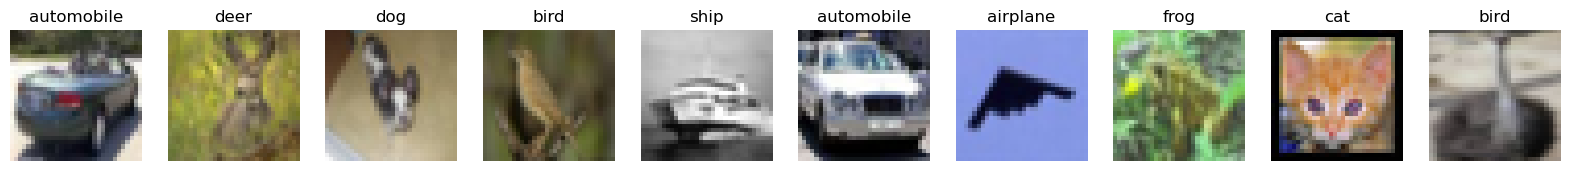

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(dataset_val[i][0].permute(1, 2, 0))
    plt.title(id2cls[dataset_val[i][1]])
    plt.axis("off")

plt.show()

### DataLoader

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
batch = next(iter(dataloader_val))
images, labels = batch
images.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

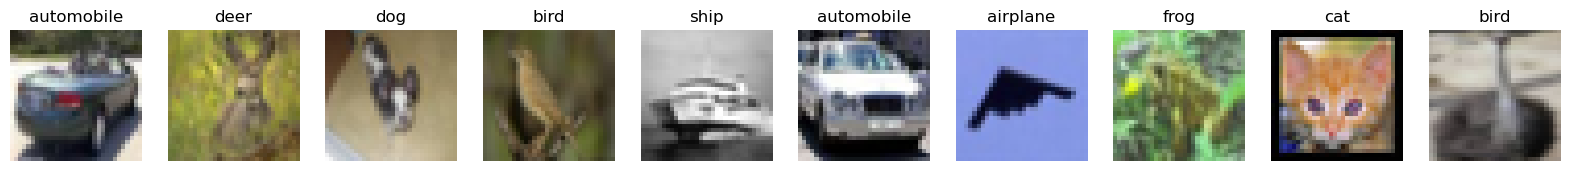

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(id2cls[labels[i].item()])
    plt.axis("off")

plt.show()

## 2. Build the model

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),

            nn.LazyLinear(200),
            nn.ReLU(),

            nn.LazyLinear(150),
            nn.ReLU(),

            nn.LazyLinear(num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = MLP(num_classes=NUM_CLASSES)
model = model.to(device)
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Linear: 2-2                       [1, 200]                  614,600
│    └─ReLU: 2-3                         [1, 200]                  --
│    └─Linear: 2-4                       [1, 150]                  30,150
│    └─ReLU: 2-5                         [1, 150]                  --
│    └─Linear: 2-6                       [1, 10]                   1,510
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.59
Estimated Total Size (MB): 2.60

## 3. Train the model

In [ ]:
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("medium")

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

accuracy_train = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
accuracy_train = accuracy_train.to(device)

accuracy_val = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
accuracy_val = accuracy_val.to(device)

In [ ]:
metrics = {
    "train": {"loss": [], "accuracy": []},
    "val": {"loss": [], "accuracy": []},
}

results_dir = Path("results")
results_dir.mkdir(exist_ok=True, parents=True)

best_accuracy = 0

n_epochs = 10
for epoch in range(n_epochs):
    # Training
    model.train()

    loss_train = 0

    tqdm_train = tqdm(dataloader_train)
    tqdm_train.set_description("Epoch {:02d}/{:2d} (Train)".format(epoch+1, n_epochs))
    for batch in tqdm_train:
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        acc = accuracy_train(preds, labels)
        loss_train += loss.item()

        tqdm_train.set_postfix_str("loss {:.4f}, accuracy {:.4f}".format(loss.item(), acc.item()))


    loss_train = loss_train / len(dataloader_train)
    acc_train = accuracy_train.compute()
    accuracy_train.reset()

    print("(Train) loss {:.4f}, accuracy {:.4f}".format(loss_train, acc_train))
    metrics["train"]["loss"].append(loss_train)
    metrics["train"]["accuracy"].append(acc_train.item())

    torch.save(model.state_dict(), results_dir/"last.pth")

    # Validation
    model.eval()

    loss_val = 0
    
    tqdm_val = tqdm(dataloader_val)
    tqdm_val.set_description("Epoch {:02d}/{:2d} (Val)  ".format(epoch+1, n_epochs))
    for batch in tqdm_val:
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(images)
            loss = criterion(logits, labels)

            preds = torch.argmax(logits, dim=1)
            accuracy_val.update(preds, labels)
            loss_val += loss.item()

    loss_val = loss_val / len(dataloader_val)
    acc_val = accuracy_val.compute()
    accuracy_val.reset()

    print("(Val)   loss {:.4f}, accuracy {:.4f}".format(loss_val, acc_val))
    metrics["val"]["loss"].append(loss_val)
    metrics["val"]["accuracy"].append(acc_val.item())

    if acc_val > best_accuracy:
        best_accuracy = acc_val
        torch.save(model.state_dict(), results_dir/"best.pth")

Epoch 01/10 (Train): 100%|██████████| 1563/1563 [00:11<00:00, 131.81it/s, loss 1.6684, accuracy 0.3125]


(Train) loss 1.8450, accuracy 0.3301


Epoch 01/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 211.62it/s]


(Val)   loss 1.7682, accuracy 0.3770


Epoch 02/10 (Train): 100%|██████████| 1563/1563 [00:12<00:00, 128.77it/s, loss 1.3400, accuracy 0.6250]


(Train) loss 1.6610, accuracy 0.4022


Epoch 02/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 195.94it/s]


(Val)   loss 1.6034, accuracy 0.4315


Epoch 03/10 (Train): 100%|██████████| 1563/1563 [00:11<00:00, 130.43it/s, loss 1.5427, accuracy 0.4375]


(Train) loss 1.5829, accuracy 0.4362


Epoch 03/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 200.82it/s]


(Val)   loss 1.5810, accuracy 0.4335


Epoch 04/10 (Train): 100%|██████████| 1563/1563 [00:12<00:00, 128.61it/s, loss 1.4010, accuracy 0.6875]


(Train) loss 1.5226, accuracy 0.4564


Epoch 04/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 192.15it/s]


(Val)   loss 1.5442, accuracy 0.4680


Epoch 05/10 (Train): 100%|██████████| 1563/1563 [00:11<00:00, 130.87it/s, loss 1.3936, accuracy 0.5625]


(Train) loss 1.4865, accuracy 0.4681


Epoch 05/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 201.33it/s]


(Val)   loss 1.4843, accuracy 0.4815


Epoch 06/10 (Train): 100%|██████████| 1563/1563 [00:12<00:00, 127.14it/s, loss 0.8890, accuracy 0.6875]


(Train) loss 1.4532, accuracy 0.4805


Epoch 06/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 182.18it/s]


(Val)   loss 1.4639, accuracy 0.4865


Epoch 07/10 (Train): 100%|██████████| 1563/1563 [00:12<00:00, 127.75it/s, loss 1.3833, accuracy 0.5625]


(Train) loss 1.4244, accuracy 0.4907


Epoch 07/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 203.27it/s]


(Val)   loss 1.4629, accuracy 0.4895


Epoch 08/10 (Train): 100%|██████████| 1563/1563 [00:12<00:00, 129.17it/s, loss 1.3579, accuracy 0.5000]


(Train) loss 1.4004, accuracy 0.4984


Epoch 08/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 202.03it/s]


(Val)   loss 1.4642, accuracy 0.4840


Epoch 09/10 (Train): 100%|██████████| 1563/1563 [00:11<00:00, 130.56it/s, loss 1.3481, accuracy 0.3750]


(Train) loss 1.3747, accuracy 0.5081


Epoch 09/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 202.49it/s]


(Val)   loss 1.4384, accuracy 0.4905


Epoch 10/10 (Train): 100%|██████████| 1563/1563 [00:12<00:00, 130.04it/s, loss 1.2975, accuracy 0.6250]


(Train) loss 1.3557, accuracy 0.5192


Epoch 10/10 (Val)  : 100%|██████████| 63/63 [00:00<00:00, 211.61it/s]

(Val)   loss 1.4681, accuracy 0.4805


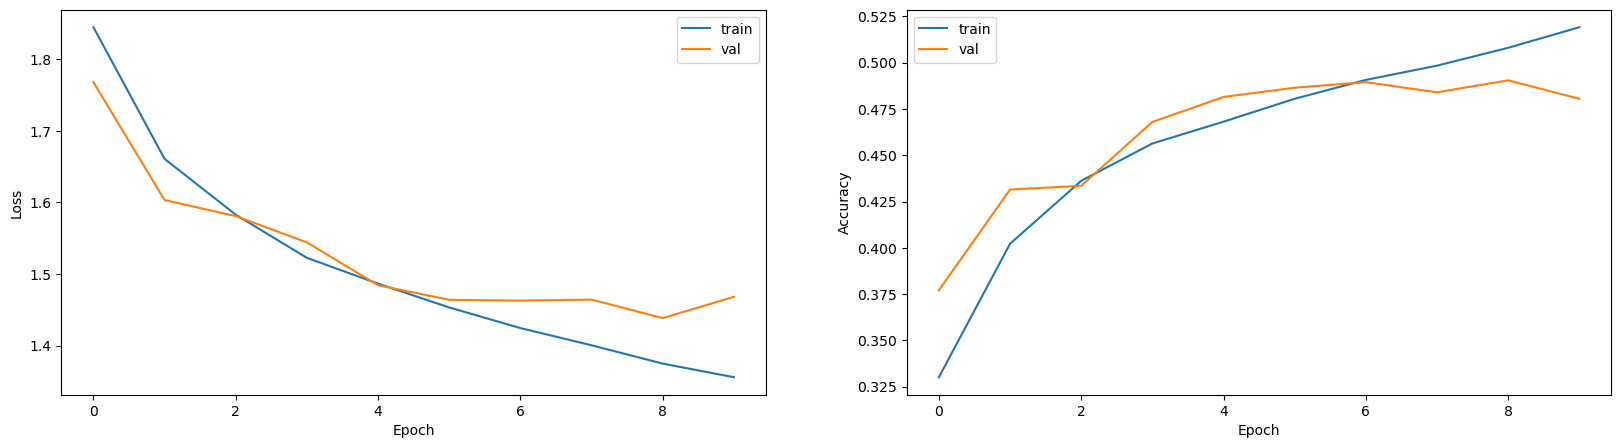

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
ax.plot(metrics["train"]["loss"], label="train")
ax.plot(metrics["val"]["loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

ax = axes[1]
ax.plot(metrics["train"]["accuracy"], label="train")
ax.plot(metrics["val"]["accuracy"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

plt.show()

## 4. Evaluation

In [ ]:
model.load_state_dict(torch.load(results_dir/"best.pth", weights_only=True))
model.eval()

acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
acc = acc.to(device)

acc_per_cls = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average=None)
acc_per_cls = acc_per_cls.to(device)

confmat = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)
confmat = confmat.to(device)

test_loss = 0
test_preds = []
test_labels = []
for batch in tqdm(dataloader_test):
    images, labels = batch 
    images, labels = images.to(device), labels.to(device)

    with torch.inference_mode():
        logits = model(images)
        loss = criterion(logits, labels)

        preds = torch.argmax(logits, dim=1)

        acc.update(preds, labels)
        acc_per_cls.update(preds, labels)
        confmat.update(preds, labels)
        test_loss += loss.item()

        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_loss = test_loss / len(dataloader_test)
test_acc = acc.compute()
acc.reset()
print("(Test)  loss {:.4f}, accuracy {:.4f}".format(test_loss, test_acc))

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

100%|██████████| 250/250 [00:01<00:00, 171.90it/s]

(Test)  loss 1.4267, accuracy 0.4938


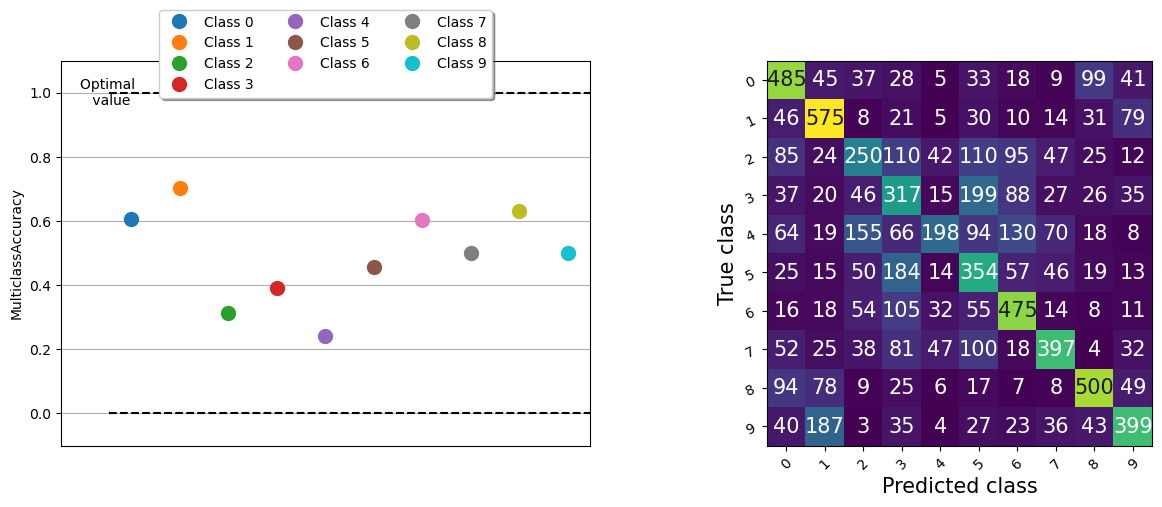

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
acc_per_cls.plot(ax=axes[0])
confmat.plot(ax=axes[1])
plt.show()

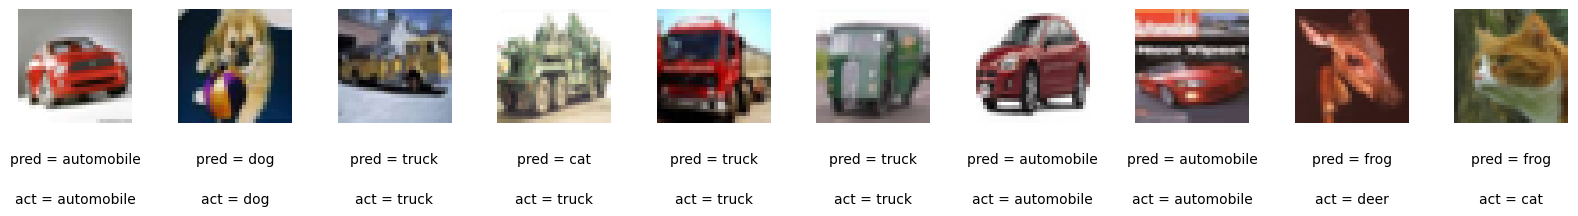

In [ ]:
n_to_show = 10
indices = np.random.choice(range(len(dataset_test)), n_to_show)

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = dataset_test[idx][0].permute(1, 2, 0)
    
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + id2cls[test_preds[idx]],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + id2cls[test_labels[idx]],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)